In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import pickle as plk

Populating the interactive namespace from numpy and matplotlib


## EDA
First we explore the database

In [2]:
df = pd.read_csv('datase.csv')
df.head()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
0,14924129,900007722,2.188069,43.430176,5500,2017-09-17T14:36:51Z,1
1,15517560,900008156,0.970423,64.589722,5200,2017-09-28T12:33:04Z,1
2,15365462,900004503,2.699022,257.006104,6700,2017-09-25T12:43:57Z,1
3,14245605,900015422,0.725768,-42.870361,3200,2017-09-05T17:17:09Z,1
4,15213594,900011745,0.750715,-34.016602,5700,2017-09-22T21:38:58Z,1


We can determine things such as the quality of the data and distribution from counts and central tendency measures

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117589 entries, 0 to 117588
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           117589 non-null  int64  
 1   store_id           117589 non-null  int64  
 2   to_user_distance   117589 non-null  float64
 3   to_user_elevation  117589 non-null  float64
 4   total_earning      117589 non-null  int64  
 5   created_at         117589 non-null  object 
 6   taken              117589 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 6.3+ MB


In [4]:
df.describe()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,taken
count,1.175890e+05,1.175890e+05,117589.000000,117589.000000,117589.000000,117589.000000
mean,1.507706e+07,7.579606e+08,1.500964,26.834768,5353.512488,0.920800
std,4.747195e+05,3.215303e+08,0.846170,84.950796,1748.985437,0.270051
min,1.421073e+07,3.000000e+07,0.000000,-598.296875,200.000000,0.000000
25%,1.466936e+07,9.000044e+08,0.835240,-18.395874,4200.000000,1.000000
50%,1.509279e+07,9.000077e+08,1.390255,11.043579,5200.000000,1.000000
75%,1.547337e+07,9.000127e+08,2.029655,61.114990,6300.000000,1.000000
max,1.590252e+07,9.000173e+08,9.360177,1009.380005,27200.000000,1.000000


Now we can process the dates

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [6]:
df['created_at'].min()

Timestamp('2017-09-05 00:01:02+0000', tz='UTC')

In [7]:
df['created_at'].max()

Timestamp('2017-10-04 23:58:53+0000', tz='UTC')

It seems we have a month's worth of data. This might not be adequate for long term predictions, but we could get back to it if the other features are not good enough for a prediction

The store id does not say much about the orders themselves, however there are some stores that are bigger than others, so we can create categories that way

In [8]:
store_df = df[['store_id', 'order_id']].groupby('store_id', as_index=False).count()
store_df.head()

,store_id,order_id
0,30000003,95
1,30000007,302
2,30000009,373
3,30000016,70
4,30000017,6


<AxesSubplot:>

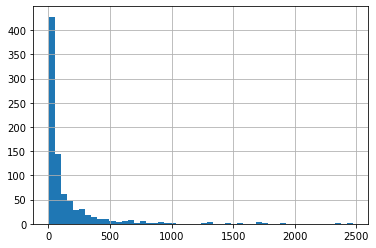

In [9]:
store_df['order_id'].hist(bins=50)

It is possible to make 4 categories according to the quantiles of the distribution

In [10]:
low = store_df['order_id'].quantile(0.25)
mid_low = store_df['order_id'].quantile(0.5)
mid_high = store_df['order_id'].quantile(0.75)

store_df['store_size'] = store_df['order_id'].apply(lambda x: 0 if x <= low else 1 if x <= mid_low else 2 if x <= mid_high else 3)

In [11]:
df = df.merge(store_df.drop(columns=['order_id']), left_on='store_id', right_on='store_id')
df.head()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken,store_size
0,14924129,900007722,2.188069,43.430176,5500,2017-09-17 14:36:51+00:00,1,3
1,15830952,900007722,1.320381,-8.719238,4500,2017-10-03 17:02:59+00:00,1,3
2,14867183,900007722,0.587164,-9.982910,3200,2017-09-16 18:29:54+00:00,1,3
3,15712067,900007722,1.383369,-8.038208,5500,2017-10-01 13:32:07+00:00,1,3
4,14285297,900007722,2.404971,18.280884,4200,2017-09-06 14:01:18+00:00,1,3


Now we can look at the pairplots and correlations to find possible relationships

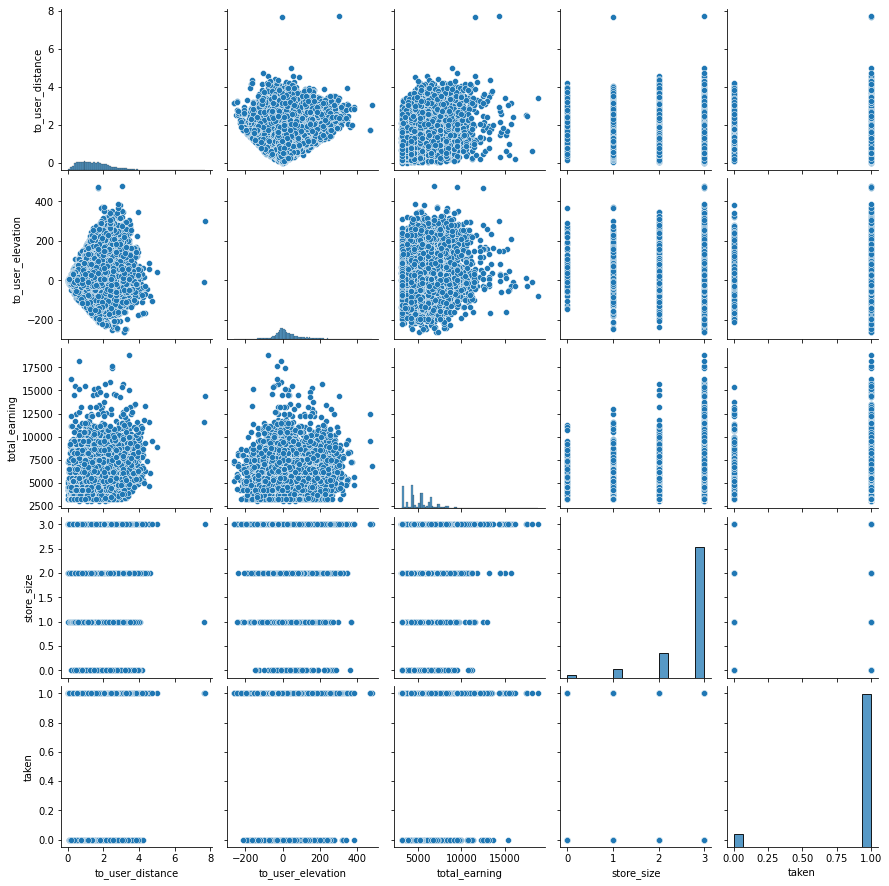

In [13]:
sns.pairplot(data=df[['to_user_distance', 'to_user_elevation', 'total_earning', 'store_size', 'taken']].sample(10000))

In [14]:
df.corr()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,taken,store_size
order_id,1.000000,-0.005511,0.051176,0.010241,0.201214,-0.000303,-0.020126
store_id,-0.005511,1.000000,-0.040686,0.022467,-0.069735,-0.016398,-0.089950
to_user_distance,0.051176,-0.040686,1.000000,0.149998,0.240567,-0.089636,-0.053162
to_user_elevation,0.010241,0.022467,0.149998,1.000000,0.106760,0.009574,-0.005690
total_earning,0.201214,-0.069735,0.240567,0.106760,1.000000,0.040270,0.004798
taken,-0.000303,-0.016398,-0.089636,0.009574,0.040270,1.000000,0.042082
store_size,-0.020126,-0.089950,-0.053162,-0.005690,0.004798,0.042082,1.000000


There does not seem to be an apparent correlation between different features, however it seems the dataset is imbalanced

In [15]:
df['taken'].value_counts()

1    108276
0      9313
Name: taken, dtype: int64

The dataset is imbalanced as we saw, so a mix of a subsampling and oversampling approach can be used to have a balanced dataset, while avoiding overfitting

In [17]:
n_samples = df['taken'].value_counts().min()*3
df_b = df.groupby('taken', as_index=False).apply(lambda x: x.sample(n_samples, replace=True)).reset_index(drop=True)
df_b.head()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken,store_size
0,15263204,900014452,1.531285,132.084839,6200,2017-09-23 18:21:01+00:00,0,3
1,14790707,900005727,1.703830,-40.875488,3700,2017-09-15 16:06:07+00:00,0,3
2,15598191,900015225,3.046265,21.854370,7650,2017-09-29 19:03:09+00:00,0,3
3,14490697,900005747,2.946726,5.067871,4400,2017-09-09 18:50:09+00:00,0,3
4,15637362,900011326,2.010649,4.876831,7150,2017-09-30 13:34:59+00:00,0,3


In [18]:
df_b['taken'].value_counts()

0    27939
1    27939
Name: taken, dtype: int64

Now we peoceed to make different pipelines in order to make the pipelines for the different alternatives after splitting the dataset in training and testing

In [19]:
X = df_b[['to_user_distance', 'to_user_elevation', 'total_earning']]
y = df_b['taken']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
test = pd.read_csv('orders_test.csv')
test.head()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at
0,14368568,30000048,1.865569,212.173218,4200,2017-09-07T20:17:17Z
1,14367873,900011220,1.113147,12.240356,5200,2017-09-07T20:18:15Z
2,14369202,900008202,2.885515,47.449707,3600,2017-09-07T20:07:23Z
3,14370107,900007625,1.545066,172.211182,3200,2017-09-07T20:19:16Z
4,14371461,900003685,2.393699,42.583374,3700,2017-09-07T20:25:20Z


In [21]:
X_val = test[['to_user_distance', 'to_user_elevation', 'total_earning']]

## Logistic regression
The first model to try is the logistic regression as there may be a linear relationship between the variables (A polynomial relationship could also happen, but this can be explored with a Support Vector Classifier

In [22]:
pipe_lr = Pipeline([('scaler', MinMaxScaler()), ('lr', LogisticRegression())])
param_grid = {'lr__C': [1, 0.5, 0.2, 0.1, 0.01]}
search_lr = GridSearchCV(pipe_lr, param_grid, n_jobs=4)
search_lr.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('lr', LogisticRegression())]),
             n_jobs=4, param_grid={'lr__C': [1, 0.5, 0.2, 0.1, 0.01]})

The accuracy is not that high, however it is worth noting that there is not an imbalance towards false positives or false negatives

In [23]:
y_pred = search_lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.5922512526843235

In [24]:
confusion_matrix(y_test, y_pred)

array([[3251, 2327],
       [2230, 3368]], dtype=int64)

Text(0.5, 1.0, 'ROC curve')

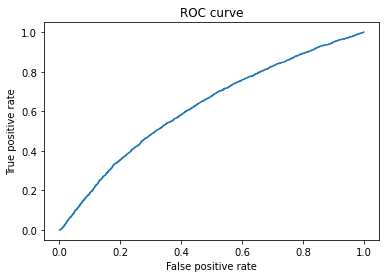

In [25]:
y_pred_proba = search_lr.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba[:, 1])
plt.plot(fpr_lr, tpr_lr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

## SVC
SVC can capture more complex interactions. In this case, a polynomial kernel will be used

In [26]:
pipe_svc = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC())])
param_grid = {'svc__C': [1, 0.5, 0.2, 0.1, 0.01], 'svc__kernel': ['poly', 'rbf', 'sigmoid']}#, 'svc__probability': [True]
search_svc = GridSearchCV(pipe_svc, param_grid, n_jobs=4)
search_svc.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svc', SVC())]),
             n_jobs=4,
             param_grid={'svc__C': [1, 0.5, 0.2, 0.1, 0.01],
                         'svc__kernel': ['poly', 'rbf', 'sigmoid']})

The accuracy improves, but not by much

In [27]:
y_pred = search_svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.6047780959198282

In [28]:
confusion_matrix(y_test, y_pred)

array([[3474, 2104],
       [2313, 3285]], dtype=int64)

## Random forest
Random forest is better suited to find complex non linear relationships, so we can try this approach

In [29]:
pipe_rf = Pipeline([('scaler', MinMaxScaler()), ('RF', RandomForestClassifier())])
param_grid = {'RF__min_samples_split': [2, 4, 8], 'RF__min_samples_leaf': [1, 2, 4, 8]}
search_rf = GridSearchCV(pipe_rf, param_grid, n_jobs=4)
search_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('RF', RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'RF__min_samples_leaf': [1, 2, 4, 8],
                         'RF__min_samples_split': [2, 4, 8]})

The accuracy improves considerably in this case, at the cost of increasing the false negatives

In [30]:
y_pred = search_rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8834108804581245

In [31]:
confusion_matrix(y_test, y_pred)

array([[5256,  322],
       [ 981, 4617]], dtype=int64)

Text(0.5, 1.0, 'ROC curve')

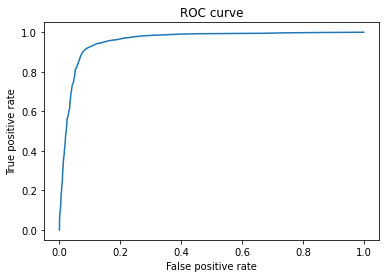

In [32]:
y_pred_proba = search_rf.predict_proba(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba[:, 1])
plt.plot(fpr_rf, tpr_rf)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

## Gradient boosting
Finally we try a gradient boosting approach

In [33]:
pipe_gb = Pipeline([('scaler', MinMaxScaler()), ('GB', GradientBoostingClassifier())])
param_grid = {'GB__learning_rate': [1, 0.1, 0.01], 'GB__n_estimators': [10, 100, 1000], 'GB__min_samples_leaf': [1, 2, 4, 8]}
search_gb = GridSearchCV(pipe_gb, param_grid, n_jobs=4)
search_gb.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('GB', GradientBoostingClassifier())]),
             n_jobs=4,
             param_grid={'GB__learning_rate': [1, 0.1, 0.01],
                         'GB__min_samples_leaf': [1, 2, 4, 8],
                         'GB__n_estimators': [10, 100, 1000]})

The accuracy is worse than with random forest in this case

In [34]:
y_pred = search_gb.predict(X_test)
accuracy_score(y_test, y_pred)

0.7833750894774517

In [35]:
confusion_matrix(y_test, y_pred)

array([[4633,  945],
       [1476, 4122]], dtype=int64)

Text(0.5, 1.0, 'ROC curve')

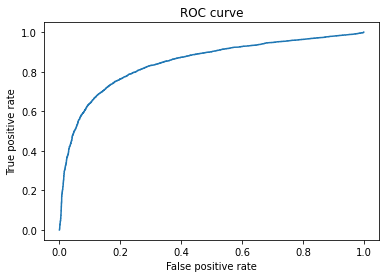

In [36]:
y_pred_proba = search_gb.predict_proba(X_test)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba[:, 1])
plt.plot(fpr_gb, tpr_gb)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

## Serialization
In order for our model to be reusable, we serialize it. In this case we will work with the random forest model

In [ ]:
with open('Predict.plk', 'wb') as f:
    plk.dump(search_rf, f)

In [5]:
test['store_id'].isin(df['store_id']).value_counts()

True     29397
False        1
Name: store_id, dtype: int64

In [42]:
store_df.drop(columns=['order_id']).to_csv('Store_sizes.csv', sep=';')